## Lab 4
### UGBA 96: Data and Decisions, Fall 2018


---


<img src='michigan_map.png'>

## The Effectiveness of a 'Get-Out-The-Vote' Campaign 

In this lab we will go over the matching method for causal infererence.

### Table of Contents

[Background](#bground) <br>
1. [The Dataset](#data) <br>
2. [Matching on a Single Covariate](#single) <br>
3. [Matching on a Set of Covariates](#set) <br>


In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

from client.api.notebook import Notebook
ok = Notebook('lab4.ok')
_ = ok.auth(inline=True)

Assignment: Lab 4
OK, version v1.12.5

Successfully logged in as ccmiller@berkeley.edu


**Warmup:** In your own words, what is the **fundamental problem of causal inference**?

*#write answer here*

----

## Background <a id='bground'></a>

Compared to other developed countries, the United States has low voter turnout rates. About 55.5% of the U.S. voting-age population casted ballots in the 2016 presidential election. In the 2000 presidential election, the turnout rate was 50.3%.

Fearing another low turnout in the 2002 midterm elections, civic groups in Iowa and Michigan launched the Vote 2002 Campaign to boost voter turnout. In the week prior to the election, Vote 2002 volunteers called 60,000 voters on the phone and gave them the following message:

*"Hello, may I speak with [name of person] please? Hi. This is [caller's name] calling from Vote 2002, a nonpartisan effort working to encourage citizens to vote. We just wanted to remind you that elections are being held this Tuesday. The success of our democracy depends on whether we exercise our right to vote or not, so we hope you'll come out and vote this Tuesday. Can I count on you to vote next Tuesday?”*

Our causal question for the day is: **Did the Vote 2002 campaign work? Did it increase voter turnout in the 2002 Congressional elections?** 

To estimate the causal effect of receving a Vote 2002 phone call, we'll need to compare the outcomes of voters that received a call--we'll call them **contacted** voters--to the outcomes for some comparison group. For our causal effect estimate to be accurate, the comparison group we use will need to reflect the *counterfactual* outcomes for contacted voters: what those voters *would have* done if they had not received the Vote 2002 call. If the comparison group poorly represents the counterfactual, our estimate will be biased.

For the comparison group to represent the counterfactual, we need the only relevant difference between contacted voters and comparison voters to be that comparison voters did not receive a phone call while contacted voters did. The idea of **matching** is to find a comparable uncontacted voter for each contacted voter, and then use that set of matches as a comparison group.

----

## Section 1: The Dataset <a id='data'></a>

The dataset we'll use was compiled by the Vote 2002 campaign staff. The staff had demographic data for each voter they attempted to contact, and marked whether each call was completed successfully or not. Later, in order to measure the impact of their campaign, they merged these data with official voting records to see if voters did go out and vote.

Here is a description of each column in the dataset:

* **contact** - indicator for whether voter was successfully contacted by volunteer
* **vote02** - indicator for whether the voter votes in the 2002 election (*this is the outcome of interest*)
* **vote98** - indicator for whether the voter voted in the 1998 election
* **newreg** - indicator for wheter voter is newly registered voter
* **age** -  age of voter
* **female** - indicator for female

The original data include over 2 million potential voters in Iowa and Michigan. In order for us to not spend the whole lab period waiting for a cell to finish running, we'll focus on a subset of the data: voters from Oakland county in Michigan (the county that contains Detroit).

In [2]:
#run this cell to load the data

#read in data
data = Table.read_table("mi_voters.csv")

data.show(5)

treatment,contact,vote02,vote98,newreg,age,female
0,0,0,0,0,45,0
0,0,1,0,0,48,1
0,0,1,0,0,38,0
0,0,0,0,0,33,0
0,0,1,1,0,44,1


**Q1.1:** Now for a coding warm-up. What percentage of voters in our data were *contacted*?

In [3]:
#assign the percentage to the variable percent_voters_contacted

percent_voters_contacted = np.mean(data.column('contact'))
percent_voters_contacted

0.016268245288987303

In [4]:
_ = ok.grade("q1_1")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Let's first check how voter turnout compares between contacted and non-contacted voters. For exercises below we'll find it useful to separate the data into two tables, one for contacted voters and the other for non-contacted voters.

In [5]:
#defines separate tables for contacted and non-contacted
contacted = data.where('contact', 1)
noncontacted = data.where('contact', 0)

contacted

treatment,contact,vote02,vote98,newreg,age,female
1,1,0,1,0,68,1
1,1,1,1,0,44,0
1,1,1,1,0,43,1
1,1,1,1,0,83,0
1,1,1,1,0,70,0
1,1,1,1,0,84,0
1,1,1,1,0,78,1
1,1,1,1,0,73,0
1,1,1,1,0,87,1
1,1,1,1,0,60,1


Next we'll calculate the turnout for each group of voters.

In [6]:
vote02_contacted = 100*np.mean(contacted.column('vote02'))
vote02_noncontacted = 100*np.mean(noncontacted.column('vote02'))

print('2002 Election Turnout Rate, Contacted Voters:', vote02_contacted)
print('2002 Election Turnout Rate, Non-Contacted Voters:', vote02_noncontacted)

2002 Election Turnout Rate, Contacted Voters: 70.83333333333334
2002 Election Turnout Rate, Non-Contacted Voters: 57.70591207680646


Finally let's plot the results in a bar plot.

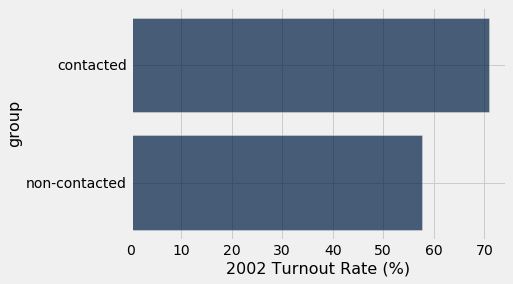

In [7]:
turnout_rates = Table().with_columns('group', ['contacted', 'non-contacted'],
                                       '2002 Turnout Rate (%)', [vote02_contacted, vote02_noncontacted])
turnout_rates.barh('group')

Indeed, contacted voters have a 15-16 percentage point higher turnout in the 2002 election.

Does this difference reflect the causal effect of receiving a call? It might. But it might not if contacted and not contacted voters are different in ways other than whether they received a call.

As a starting point, let's compare the age distributions for the two groups of voters.

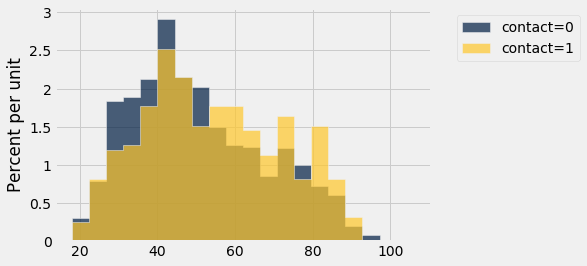

In [8]:
data.hist('age', group = 'contact', bins = 20)

**Q1.2:** Why might the chart above suggest that simply comparing contacted and non-contacted voters will lead to a *biased* estimate for the average causal effect of receiving a call?

*#Write your answer here*

----

## Section 2: Matching on a Single Covariate <a id='single'></a>

To account for these differences in age across the two voter populations, let's try to *'control for'* age via matching. That is, for each contacted voter, we'll find a non-contacted voter with the same age, and use the set of matched non-contacted voters as our comparison group.

First let's assign ID's to people in the control group. It will soon become clear why we're doing this.

In [9]:
#add ID column
noncontacted = noncontacted.with_column('id', np.arange(noncontacted.num_rows))
noncontacted.show(5)

treatment,contact,vote02,vote98,newreg,age,female,id
0,0,0,0,0,45,0,0
0,0,1,0,0,48,1,1
0,0,1,0,0,38,0,2
0,0,0,0,0,33,0,3
0,0,1,1,0,44,1,4


**Q2.1:** Write a function that takes in an `age` value and returns the ID of a randomly chosen non-contacted adult with the given age.

In [10]:
#write your code here
def match_age_id(age_value):
    matching_table = noncontacted.where('age', age_value)
    if(matching_table.num_rows >= 1):
        return matching_table.sample(1).column('id').item(0)
    else:
        return None

**Q2.2:** Let's test the function you've written. Find an age match for the first row in the `contacted` table.

In [11]:
#run this cell to observe first row from `contacted` table
contacted.take(0)

treatment,contact,vote02,vote98,newreg,age,female
1,1,0,1,0,68,1


In [12]:
#run your function
match_age_id(54)

4255

In [13]:
#confirm your match has the same age
noncontacted.where('id', 29102)

treatment,contact,vote02,vote98,newreg,age,female,id


**Q2.3:** How many potential age matches could you have chosen?

In [14]:
#write code here
noncontacted.where('age', 49).num_rows

417

**Q2.4** Use your function `match_age_id` to create a table of non-matched voters (called `noncontacted_age_matches`) that corresponds to the matches for each row in the `contacted` table. (Hint: remember .take). **The code may take a couple minutes to run**, so feel free to answer the next question (**Q2.5**) while the notebook executes the code.

In [15]:
#use .apply get array of matched noncontacted voters
match_indices = contacted.apply(match_age_id, 'age')

#use .take and `match_indices` to get a table of matched noncontacted voters
noncontacted_age_matches = noncontacted.take(match_indices)
noncontacted_age_matches.show(10)


treatment,contact,vote02,vote98,newreg,age,female,id
0,0,0,1,0,68,0,3158
0,0,0,0,1,44,0,20194
0,0,1,0,0,43,0,9653
0,0,0,0,0,83,1,6059
0,0,1,0,0,70,0,17947
0,0,1,0,0,84,1,5469
0,0,1,0,0,78,1,9328
0,0,1,0,0,73,0,1670
0,0,1,0,0,87,1,17929
0,0,1,0,0,60,1,11905


In [16]:
_ = ok.grade("q2_4")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



**Q2.5:** For your matching function, what is the downside of selecting *one random row* for matching? How could we utilize data from all matched rows?

*#write answer here*

**Q2.6:** Compare the age distributions of `contacted` voters to *matched* `noncontacted` voters. What do you notice?

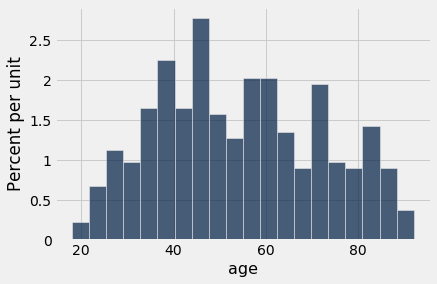

In [17]:
#plot histogram for `contacted` voters
contacted.hist('age', bins = 20)

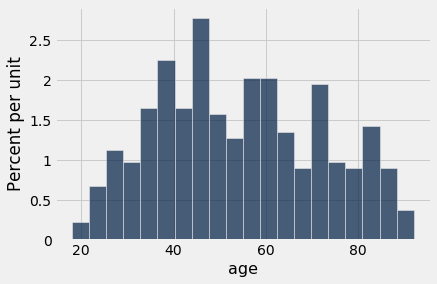

In [18]:
#plot histogram for `noncontacted_age_matches` voters
noncontacted_age_matches.hist('age', bins = 20)

*#What do you notice?*

We have controlled for age via matching. Let's see how this changes our estimate for the effect of receiving a Vote 2002 call on turnout. We'll compare 2002 turnout rates for our three groups of voters. [*Note that because your matching procedure has a random component, your results will not match you neighbors exactly.*]

In [19]:
#same as above, just adding turnout rate for noncontacted matches (matched on age)
vote02_contacted = 100*np.mean(contacted.column('vote02'))
vote02_noncontacted = 100*np.mean(noncontacted.column('vote02'))
vote02_noncontacted_age_matches = 100*np.mean(noncontacted_age_matches.column('vote02'))

print('2002 Election Turnout Rate, Contacted Voters:', vote02_contacted)
print('2002 Election Turnout Rate, Non-Contacted Voters:', vote02_noncontacted)
print('2002 Election Turnout Rate, Age Matched Non-Contacted Voters:', vote02_noncontacted_age_matches)

2002 Election Turnout Rate, Contacted Voters: 70.83333333333334
2002 Election Turnout Rate, Non-Contacted Voters: 57.70591207680646
2002 Election Turnout Rate, Age Matched Non-Contacted Voters: 67.5


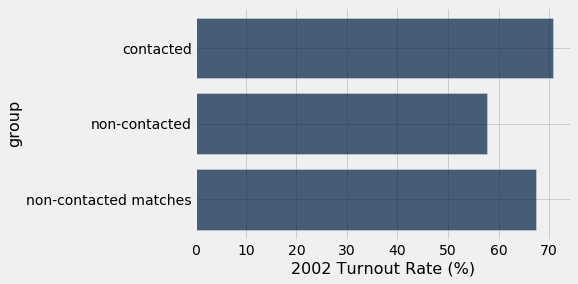

In [20]:
turnout_rates = Table().with_columns('group', ['contacted', 'non-contacted', 'non-contacted matches'],
                                       '2002 Turnout Rate (%)', [vote02_contacted, vote02_noncontacted, vote02_noncontacted_age_matches])
turnout_rates.barh('group')

**Q2.7:** How do the matched (on age) non-contacted voters compare?

*#write your answer here*

We've controlled for age, but what about the other covariates available to us? How do they compare across our three groups? Let's examine `vote98`, and indicator for whether the voter voted in the 1998 congressional election.

**Q2.8:** Adopting the code from the two code cells above, compare the *1998* turnout rates for our three groups. 

In [21]:
#print 1998 turnout rates for three groups
vote98_contacted = 100*np.mean(contacted.column('vote98'))
vote98_noncontacted = 100*np.mean(noncontacted.column('vote98'))
vote98_noncontacted_age_matches = 100*np.mean(noncontacted_age_matches.column('vote98'))

print('1998 Election Turnout Rate, Contacted Voters:', vote98_contacted)
print('1998 Election Turnout Rate, Non-Contacted Voters:', vote98_noncontacted)
print('1998 Election Turnout Rate, Age Matched Non-Contacted Voters', vote98_noncontacted_age_matches)

1998 Election Turnout Rate, Contacted Voters: 30.0
1998 Election Turnout Rate, Non-Contacted Voters: 25.384721392806288
1998 Election Turnout Rate, Age Matched Non-Contacted Voters 29.166666666666668


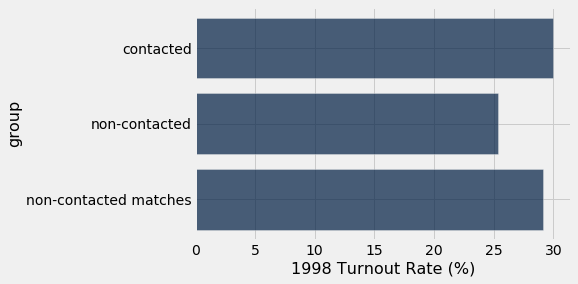

In [22]:
#make bar plot here
turnout_rates = Table().with_columns('group', ['contacted', 'non-contacted', 'non-contacted matches'],
                                       '1998 Turnout Rate (%)', [vote98_contacted, vote98_noncontacted, vote98_noncontacted_age_matches])
turnout_rates.barh('group')

**Q2.9:** How do these turnout rates compare? Are our non-contacted matches a good comparison group? (Remember that 1998 turnout is a *covariate* in this context, not our outcome of interest.)

*#write answer here*

## Section 3: Matching on a Set of Covariates <a id='set'></a>

Matching on `age` alone produces a comparison group that is still unbalanced on some dimensions. Let's try matching on all the covariates available to us.

**Q3.1:** Extend the function you wrote in **Q2.1** to match on four covariates: `age`, `newreg`, `female`, and `vote98`.

The function should take as input a value for each covariate and returns the ID of a randomly chosen non-contacted adult with the same values for those covariates.

In [23]:
#write your code here
def match_full_id(age_value, newreg_value, female_value, vote98_value):
    matching_table = noncontacted.where('age', age_value).where('newreg', newreg_value).where('female', female_value).where('vote98', vote98_value)
    if(matching_table.num_rows >= 1):
        return matching_table.sample(1).column('id').item(0)
    else:
        return None

**Q3.2:** As we did before, let's test the new function you've written. Find a match for the first row in the `contacted` table.

In [24]:
contacted.take(0)

treatment,contact,vote02,vote98,newreg,age,female
1,1,0,1,0,68,1


In [25]:
#run your function
match_full_id(49, 0, 0, 0)

7209

In [26]:
#confirm your match has the same values for: `age`, `newreg`, `female`, and `vote98`
noncontacted.where('id', 3644)

treatment,contact,vote02,vote98,newreg,age,female,id
1,0,1,1,0,79,1,3644


**Q3.3:** As you did in **Q2.4**, Use `match_full_id` to create a table of non-matched voters (called `noncontacted_full_matches`) that corresponds to the matches for reach row in the `contacted` table. **The code may take a couple minutes to run.**

In [27]:
full_match_indices = contacted.apply(match_full_id, 'age', 'newreg', 'female', 'vote98')
noncontacted_full_matches = noncontacted.take(full_match_indices)
noncontacted_full_matches

treatment,contact,vote02,vote98,newreg,age,female,id
0,0,1,1,0,68,1,11609
0,0,1,1,0,44,0,9696
0,0,1,1,0,43,1,1932
0,0,0,1,0,83,0,3881
0,0,1,1,0,70,0,11957
0,0,1,1,0,84,0,3168
0,0,1,1,0,78,1,10944
0,0,1,1,0,73,0,2073
0,0,1,1,0,87,1,2822
0,0,1,1,0,60,1,11452


In [28]:
_ = ok.grade("q3_3")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



**Q3.4:** Check for balance between `contacted` and matched `noncontacted` for *one* of these covariates: `newreg`, `female`, or `vote98`.

In [29]:
#print the mean of covariate for both groups
vote98_contacted = 100*np.mean(contacted.column('vote98'))
vote98_noncontacted = 100*np.mean(noncontacted.column('vote98'))
vote98_noncontacted_age_matches = 100*np.mean(noncontacted_age_matches.column('vote98'))
vote98_noncontacted_full_matches = 100*np.mean(noncontacted_full_matches.column('vote98'))

print('1998 Election Turnout Rate, Contacted Voters:', vote98_contacted)
print('1998 Election Turnout Rate, Non-Contacted Voters:', vote98_noncontacted)
print('1998 Election Turnout Rate, Age Matched Non-Contacted Voters:', vote98_noncontacted_age_matches)
print('1998 Election Turnout Rate, Fully Matched Non-Contacted Voters:', vote98_noncontacted_full_matches)

1998 Election Turnout Rate, Contacted Voters: 30.0
1998 Election Turnout Rate, Non-Contacted Voters: 25.384721392806288
1998 Election Turnout Rate, Age Matched Non-Contacted Voters: 29.166666666666668
1998 Election Turnout Rate, Fully Matched Non-Contacted Voters: 30.0


Finally, let's look at how 2002 turnout rates look like in our new and improved matched comparison group.

In [30]:
vote02_contacted = 100*np.mean(contacted.column('vote02'))
vote02_noncontacted = 100*np.mean(noncontacted.column('vote02'))
vote02_noncontacted_age_matches = 100*np.mean(noncontacted_age_matches.column('vote02'))
vote02_noncontacted_full_matches = 100*np.mean(noncontacted_full_matches.column('vote02'))

print('2002 Election Turnout Rate, Contacted Voters:', vote02_contacted)
print('2002 Election Turnout Rate, Non-Contacted Voters:', vote02_noncontacted)
print('2002 Election Turnout Rate, Age Matched Non-Contacted Adults:', vote02_noncontacted_age_matches)
print('2002 Election Turnout Rate, Fully Matched Non-Contacted Adults:', vote02_noncontacted_full_matches)

2002 Election Turnout Rate, Contacted Voters: 70.83333333333334
2002 Election Turnout Rate, Non-Contacted Voters: 57.70591207680646
2002 Election Turnout Rate, Age Matched Non-Contacted Adults: 67.5
2002 Election Turnout Rate, Fully Matched Non-Contacted Adults: 60.55555555555555


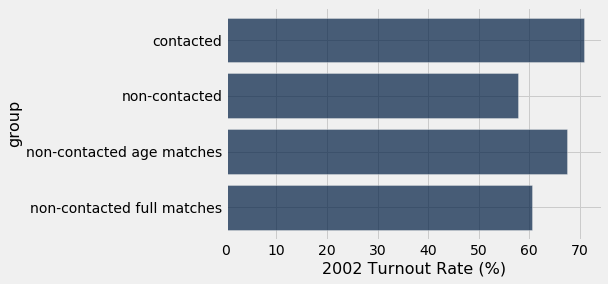

In [31]:
turnout_rates = Table().with_columns('group', ['contacted', 'non-contacted', 'non-contacted age matches', 'non-contacted full matches'],
                                       '2002 Turnout Rate (%)', [vote02_contacted, vote02_noncontacted, vote02_noncontacted_age_matches, vote02_noncontacted_full_matches])
turnout_rates.barh('group')

**Q3.5:** Using our matched comparison group, what would we estimate for the causal effect of receiving a Vote 2002 call on turnout?

*#write your answer here*

Finally, we will test whether the difference in turnout rates between contacted voters and matched noncontacted voters that we measured above is *statistically significant*. As in the previous lab, we will use a *permutation test* to answer this question. We'll use the function `permuted_sample_average_difference`.

In [32]:
#Run this cell to define the function permuted_sample_average_difference 
def permuted_sample_average_difference(table, label, group_label, repetitions):

    tbl = table.select(group_label, label)

    differences = make_array()
    for i in np.arange(repetitions):
        shuffled = tbl.sample(with_replacement = False).column(1)
        original_and_shuffled = tbl.with_column('Shuffled Data', shuffled)

        shuffled_means = original_and_shuffled.group(group_label, np.average).column(2)
        simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)

        differences = np.append(differences, simulated_difference)

    return differences

Run the cell below to conduct a permutation test. **This may take a couple minutes to run.**

In [33]:
##run this cell to conduct permutation test

#create table that combines `contacted` and `noncontated_full_matches`
contact = np.concatenate((contacted.column('contact'), noncontacted_full_matches.column('contact')))
vote02 = np.concatenate((contacted.column('vote02'), noncontacted_full_matches.column('vote02')))

combined = Table().with_columns('contact', contact, 'vote02', vote02)

#calculate different in 2002 voter turnout
vote02_diff = combined.where('contact', 1).column('vote02').mean() - combined.where('contact', 0).column('vote02').mean()

#assign array of simulated test statistics under null
vote02_sim_diff = permuted_sample_average_difference(combined, 'vote02', 'contact', 10000)

#assign p-value
vote02_pvalue = np.count_nonzero(abs(vote02_sim_diff) >= abs(vote02_diff))/10000

#print results
print('estimated treatment effect =', 100*vote02_diff)
print('p_value =', vote02_pvalue)


estimated treatment effect = 10.277777777777786
p_value = 0.0047


**Q3.6:** Are you convinced that the Vote 2002 mobilization effor increased voter turnout? Why or why not?

*#write your answer here*

----
Congratulations, you've finished Lab 4! To submit the lab, run the two cells below:

In [34]:
# For your convenience, you can run this cell to run all the tests at once
import os
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



In [ ]:
_ = ok.submit()

<IPython.core.display.Javascript object>